In [2]:
import numpy as np
import os
import shutil
import torchvision
import torch.nn as nn
import torch
from torchvision import datasets, models, transforms
import random
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.cm as cm
import cv2

In [2]:
def get_class_names(dirs):
    class_names = {}
    for dir_path in dirs:
        temp = [name for name in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, name))]
        class_names[dir_path] = temp 
    return class_names

# Large Scale Fish Dataset
data_dir=r'/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

# Life Clef Fish Dataset
data_dir2=r'/kaggle/input/life-clef-data/life_clef_data'

# add any extra data paths to dirs list to get class names
dirs = [data_dir, data_dir2]

class_names = get_class_names(dirs)
print(f'Total Directories of Data: {len(dirs)}\n')
total_species = sum([len(i) for i in class_names.values()])
print(f'Total Species Count: {total_species}\n')
for key, value in class_names.items():
    print(f'Data Path: {key}')
    print(f'{value}\n')

# Creates list of class names alphabetically
a, b = class_names.values()
temp = a + b
temp = sorted(temp)

# Creates dict of class names associated with index
class_labels = {}
idx = 0
for value in temp:
    class_labels[idx] = value
    idx += 1

print(f'Class Labels:')
class_labels

Total Directories of Data: 2

Total Species Count: 24

Data Path: /kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset
['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet', 'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream', 'Red Sea Bream']

Data Path: /kaggle/input/life-clef-data/life_clef_data
['Acanthurus nigrofuscus', 'Abudefduf vaigiensis', 'Neoglyphidodon nigroris', 'Chromis chrysura', 'Chaetodon speculum', 'Hemigymnus melapterus', 'Pempheris Vanicolensis', 'Zebrasoma scopas', 'Plectrogly-Phidodon dickii', 'Chaetodon trifascialis', 'Amphiprion clarkii', 'Dascyllus aruanus', 'Dascyllus reticulatus', 'Chaetodon lunulatus', 'Myripristis kuntee']

Class Labels:


{0: 'Abudefduf vaigiensis',
 1: 'Acanthurus nigrofuscus',
 2: 'Amphiprion clarkii',
 3: 'Black Sea Sprat',
 4: 'Chaetodon lunulatus',
 5: 'Chaetodon speculum',
 6: 'Chaetodon trifascialis',
 7: 'Chromis chrysura',
 8: 'Dascyllus aruanus',
 9: 'Dascyllus reticulatus',
 10: 'Gilt-Head Bream',
 11: 'Hemigymnus melapterus',
 12: 'Hourse Mackerel',
 13: 'Myripristis kuntee',
 14: 'Neoglyphidodon nigroris',
 15: 'Pempheris Vanicolensis',
 16: 'Plectrogly-Phidodon dickii',
 17: 'Red Mullet',
 18: 'Red Sea Bream',
 19: 'Sea Bass',
 20: 'Shrimp',
 21: 'Striped Red Mullet',
 22: 'Trout',
 23: 'Zebrasoma scopas'}

In [3]:
# new folder for your train and validation folders
base_dir = "/kaggle/working/FishDataset"   
os.makedirs(base_dir, exist_ok=True)

# new folder for training set
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

# new folder for validation set
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)

# new folder for test set
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

for key,value in class_names.items():
    for cls in value:       
        cls_dir = os.path.join(key, cls)
        if key == data_dir:
            cls_dir = os.path.join(cls_dir, cls)
            
        files = os.listdir(cls_dir)
        random.shuffle(files)
        
        # split dataset to training and validation 
        split_point = int(0.7 * len(files))   # training percentage is 0.7 --> %70
        split_point2 = int(0.85 * len(files))
        train_files = files[:split_point]
        validation_files = files[split_point:split_point2]
        test_files = files[split_point2:]
        
        train_cls_dir = os.path.join(train_dir, cls)
        os.makedirs(train_cls_dir, exist_ok=True)
        
        validation_cls_dir = os.path.join(validation_dir, cls)
        os.makedirs(validation_cls_dir, exist_ok=True)
    
        test_cls_dir = os.path.join(test_dir, cls)
        os.makedirs(test_cls_dir, exist_ok=True)
    
        # copy files to the folders
        for file in train_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(train_cls_dir, file)
            shutil.copyfile(src, dst)
            
        for file in validation_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(validation_cls_dir, file)
            shutil.copyfile(src, dst)
    
        for file in test_files:
            src = os.path.join(cls_dir, file)
            dst = os.path.join(test_cls_dir, file)
            shutil.copyfile(src, dst)

print("Train/Test Split Complete")

Train/Test Split Complete


In [ ]:
#### USEFUL FOR CHECKING DIRECTORY CONTENTS (use Ctrl + /)####

# def check_directory(dir_path):
#     for dirpath, dirnames, filenames in os.walk(dir_path):
#         print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")
        

# check_directory("/kaggle/working/FishDataset")

In [4]:
def is_image_corrupted(image_path):
    """
    Checks if an image is corrupted.

    Args:
        image_path: Path to the image file.

    Returns:
        True if the image is corrupted, False otherwise.
    """
    try:
        img = Image.open(image_path)
        img.verify()  # Verify the file is not truncated
        img.close()  # Close the image after verification
        return False
    except Exception as e:
        print(f"Error: {e}")
        return True

def find_corrupted_images(directory):
    """
    Finds corrupted images within a directory.
    
    Args:
      directory: Path to the directory to search.
    """
    corrupted_files = []
    for root, _, files in os.walk(directory):
        for file in files:
          if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(root, file)
            if is_image_corrupted(file_path):
              corrupted_files.append(file_path)
    
    if len(corrupted_files) == 0:
        print(f'No corrupted files in {directory}!')
    else:
        print(f'\nList of corrupted files:\n{corrupted_files}\n...REMOVED')
        for name in corrupted_files:
            os.remove(name)
  
find_corrupted_images('/kaggle/working/FishDataset')

Error: cannot identify image file '/kaggle/working/FishDataset/test/Abudefduf vaigiensis/sample50.png'

List of corrupted files:
['/kaggle/working/FishDataset/test/Abudefduf vaigiensis/sample50.png']
...REMOVED


In [5]:
transform_mbv3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=transform_mbv3) 

validation_data = datasets.ImageFolder(root=validation_dir, 
                                 transform=transform_mbv3)

test_data = datasets.ImageFolder(root=test_dir,
                                transform=transform_mbv3)

train_set = DataLoader(dataset=train_data, 
                              batch_size=32, 
                              shuffle=True)

validation_set = DataLoader(dataset=validation_data, 
                             batch_size=32, 
                             shuffle=False) 

test_set = DataLoader(dataset=test_data, 
                             batch_size=32, 
                             shuffle=False)

In [6]:
train_accuracies=[]
validation_accuracies=[]

# Function for training
def train(dataloader, model, loss_fn, optimizer, epoch):
    
    size = len(dataloader.dataset) # total number of images inside of loader
    num_batches = len(dataloader) # number of batches
    
    model.train()

    train_loss, correct = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update training loss
        train_loss += loss.item() # item() method extracts the loss’s value as a Python float

        # Calculate training accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    # Calculate average training loss and accuracy
    train_loss = train_loss / num_batches
    accuracy = 100 * correct / size

    train_accuracies.append(accuracy)

    # Print training accuracy and loss at the end of epoch
    print(f" Training Accuracy: {accuracy:.2f}%, Training Loss: {train_loss:.4f}")

def validation(dataloader, model, loss_fn,t):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    validation_loss, correct = 0, 0

    model.eval()
    
    with torch.no_grad(): #  disable gradient calculation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    

    validation_loss /= num_batches
    accuracy = 100 * correct / size

    validation_accuracies.append(accuracy)

    # Print test accuracy and loss at the end of epoch
    print(f" Validation Accuracy: {accuracy:.2f}%, Validation Loss: {validation_loss:.4f}")

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
model = models.mobilenet_v3_small(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 98.9MB/s]


In [9]:
# Number aligns with species in folder
model.classifier[3] = nn.Linear(model.classifier[3].in_features, total_species)
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
epochs = 4
for t in range(epochs):
    print(f"Epoch {t+1}")
    train(train_set, model, loss_fn, optimizer,t)
    validation(validation_set, model, loss_fn,t)
    print("----------------------------")
print("Done!")

Epoch 1
 Training Accuracy: 94.97%, Training Loss: 0.1733
 Validation Accuracy: 96.06%, Validation Loss: 0.1395
----------------------------
Epoch 2
 Training Accuracy: 98.77%, Training Loss: 0.0413
 Validation Accuracy: 96.08%, Validation Loss: 0.1228
----------------------------
Epoch 3
 Training Accuracy: 98.53%, Training Loss: 0.0510
 Validation Accuracy: 98.18%, Validation Loss: 0.0698
----------------------------
Epoch 4
 Training Accuracy: 99.29%, Training Loss: 0.0252
 Validation Accuracy: 97.86%, Validation Loss: 0.0778
----------------------------
Done!


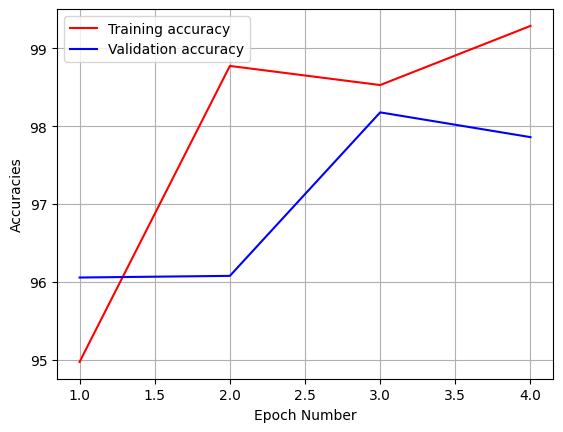

In [12]:
def visualize(train_accuracies,validation_accuracies):
    epoch_number=len(train_accuracies)

    plt.plot(range(1,epoch_number+1),train_accuracies,'r', label='Training accuracy')
    plt.plot(range(1,epoch_number+1),validation_accuracies,'b', label='Validation accuracy')
    plt.legend()
    plt.xlabel("Epoch Number")
    plt.ylabel("Accuracies")
    plt.grid()

visualize(train_accuracies,validation_accuracies)

In [13]:
def evaluate(model, dataloader):
    size = len(dataloader.dataset)
    
    correct = 0

    model.eval()
    
    with torch.no_grad(): #  disable gradient calculation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    accuracy = 100 * correct / size

    print(f"Test Accuracy: {accuracy:.2f}%")

evaluate(model, test_set)

Test Accuracy: 97.88%


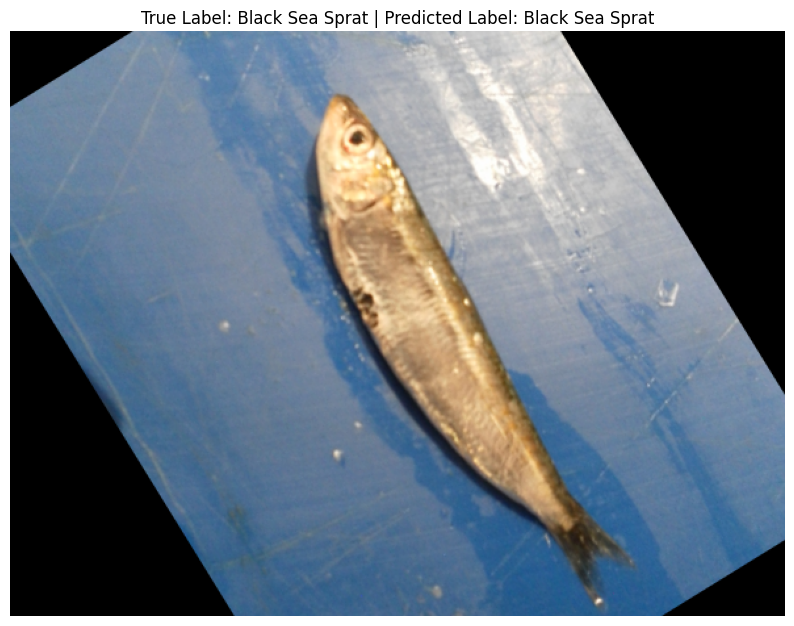

In [15]:
# change depending on which image to display
img_path = "/kaggle/working/FishDataset/test/Black Sea Sprat/00004.png"

def display_example(img_path, model):
    image = Image.open(img_path)
    true_label = img_path.split("/")[5]
    tuned_image = transform_mbv3(image)
    tuned_image = tuned_image.unsqueeze(dim=0)
    pred = model(tuned_image.to(device)).argmax(1).item()
    plt.figure(figsize=(10,8))
    plt.axis('off')
    plt.title(f"True Label: {true_label} | Predicted Label: {class_labels[pred]}")
    plt.imshow(image)

display_example(img_path, model)

In [ ]:
saved_model_path = "/kaggle/working/mbv3_v2.pth"
torch.save(model.state_dict(), saved_model_path)

In [ ]:
loaded_model = models.mobilenet_v3_small(pretrained=True)
num_classes = total_species  # Change this to the number of classes in your dataset
loaded_model.classifier[3] = nn.Linear(loaded_model.classifier[3].in_features, num_classes)

saved_model_path = "/kaggle/input/mobilenetv3-weights/mbv3_v2.pth"
loaded_model.load_state_dict(torch.load(saved_model_path, weights_only=True, map_location=torch.device(device)))

In [ ]:
#### CHECK IF WORKS IN FUTURE ####

evaluate(loaded_model.to(device), test_set)

## GRAD-CAM

### Loading in saved model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model = models.mobilenet_v3_small(pretrained=True)
num_classes = total_species  # Change this to the number of classes in your dataset
loaded_model.classifier[3] = nn.Linear(loaded_model.classifier[3].in_features, num_classes)

saved_model_path = "/kaggle/input/mobilenetv3-weights/mbv3_v2.pth"
loaded_model.load_state_dict(torch.load(saved_model_path, weights_only=True, map_location=torch.device(device)))

In [122]:
# making GRADCAM Folder
root_dir = "/kaggle/working/GRADCAM/"
os.makedirs(root_dir, exist_ok=True)

#no_normalization = transforms.Compose([
#    transforms.Resize(size=256),
#    transforms.CenterCrop(224),
#])

grad_set = DataLoader(dataset=test_data, batch_size=1)
img, _ = next(iter(grad_set))
img = np.squeeze(img.numpy()).T

# Image is normalized
# plt.imshow(img)

Text(0.5, 1.0, 'Original image')

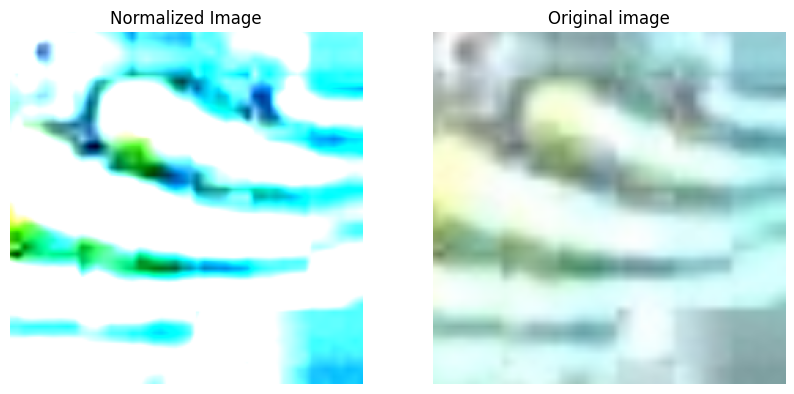

In [107]:
def unnormalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Reverses the normalization applied during preprocessing to restore the original image values.
    This is useful for visualization, as deep learning models often use normalized inputs,
    which may not be human interpretable.
    """
    #img = img_tensor.transpose(2,1,0)  # Convert PyTorch tensor to NumPy array and reorder dimensions
    img = std * img_tensor + mean  # Denormalize using mean and std deviation values
    img = np.clip(img, 0, 1)  # Ensure values remain in the valid image range [0,1]
    return img

orig_img = unnormalize(img)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].axis("off")
axes[0].set_title("Normalized Image")

axes[1].imshow(orig_img)
axes[1].axis("off")
axes[1].set_title("Original image")

In [130]:
root_dir = "/kaggle/working/GRADCAM/"
class_dir = "/kaggle/working/GRADCAM/Gilt-Head Bream"

# MUST ADJUST EVERY SESSION
img_path = "/kaggle/working/GRADCAM/Gilt-Head Bream/00006.png"
src = "/kaggle/working/FishDataset/test/Gilt-Head Bream/00006.png"

# making GRADCAM Folder
os.makedirs(class_dir, exist_ok=True)

# copying over img to new folder
shutil.copyfile(src, img_path)

#no_normalization = transforms.Compose([
#    transforms.Resize(size=256),
#    transforms.CenterCrop(224),
#])

single_dataset = datasets.ImageFolder(root=root_dir, transform=transform_mbv3)

single_set = DataLoader(dataset=single_dataset, shuffle=False, batch_size=1)

In [131]:
class GradModel(nn.Module):
    def __init__(self, base_model):
        super(GradModel, self).__init__()
        self.base_model = base_model
        self.features_conv = self.base_model.features
        self.adapt_avg_pool = self.base_model.avgpool
        self.classifier = self.base_model.classifier
        self.gradients = None

    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        h = x.register_hook(self.activations_hook)
        x = self.adapt_avg_pool(x)
        x = x.view((1, 576))
        x = self.classifier(x)
        return x

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

grad_model = GradModel(model.cpu())
grad_model.eval()
img, _ = next(iter(single_set))
pred = grad_model(img)

In [132]:
new_img = img.squeeze().permute(2,1,0)
plt.imshow(new_img)

In [134]:
# prediction for class
class_num = torch.argmax(pred[0]).item()
class_num

10

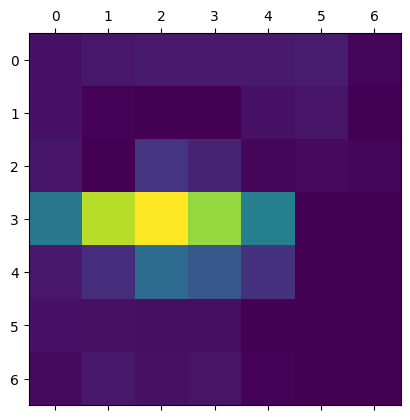

In [135]:
pred[:, class_num].backward()

gradients = grad_model.get_activations_gradient()

pooled_gradients = torch.mean(gradients, dim=[0,2,3])

activations = grad_model.get_activations(img).detach()

size = activations.shape[1]

for i in range(size):
    activations[:, i, :, :] *= pooled_gradients[i]

heatmap = torch.mean(activations, dim=1).squeeze()

heatmap = np.maximum(heatmap, 0)

heatmap /= torch.max(heatmap)

plt.matshow(heatmap.squeeze())

In [137]:
img = cv2.imread('/kaggle/working/GRADCAM/Gilt-Head Bream/00006.png')
heatmap = heatmap.numpy()
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('/kaggle/working/GRADCAM/heatmap.png', superimposed_img)

True

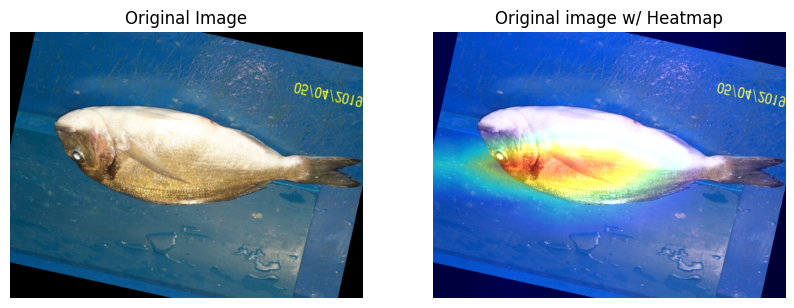

In [138]:
def display_grad(orig_img_path, heatmap_path):
    orig_img = Image.open(orig_img_path)
    heatmap_img = Image.open(heatmap_path)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(orig_img)
    axes[0].axis("off")
    axes[0].set_title("Original Image")
    
    axes[1].imshow(heatmap_img)
    axes[1].axis("off")
    axes[1].set_title("Original image w/ Heatmap")

heatmap_path = '/kaggle/working/GRADCAM/heatmap.png'
display_grad(img_path, heatmap_path)

# YOLO

In [ ]:
!pip install ultralytics

In [3]:
from ultralytics import YOLO

# make YOLO dir
yolo_dir = "/kaggle/working/YOLO"
train_dir = os.path.join(yolo_dir, "train")
val_dir = os.path.join(yolo_dir, "valid")
test_dir = os.path.join(yolo_dir, "test")

data_dir = "/kaggle/input/deep-fish-object-detection/Deepfish"

os.makedirs(yolo_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

#model = YOLO('yolo11n.pt')
loaded_model = YOLO('/kaggle/working/runs/detect/train2/weights/best.pt')

In [141]:
# Data preprocessing
def seperate_data(directory):
    counter = 1
    for (dirpath, dirnames, filenames) in os.walk(directory):
        if "train" in dirpath:
            for filename in filenames:
                img_path = os.path.join(dirpath, filename)
                dest = os.path.join(train_dir, filename)                
                shutil.copyfile(img_path, dest)
        else:
            for filename in filenames:
                if counter:
                    img_path = os.path.join(dirpath, filename)
                    dest = os.path.join(val_dir, filename)
                    shutil.copyfile(img_path, dest)
                    counter = 0
                else:
                    img_path = os.path.join(dirpath, filename)
                    dest = os.path.join(test_dir, filename)
                    shutil.copyfile(img_path, dest)  
                    counter = 1

seperate_data("/kaggle/input/deep-fish-object-detection/Deepfish")

In [8]:
model.train(data="/kaggle/input/yolo-yaml/data.yml", epochs=5, imgsz=1024, batch=4)

Ultralytics 8.3.121 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/yolo-yaml/data.yml, epochs=5, time=None, patience=100, batch=4, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_

train: Scanning /kaggle/working/YOLO/train.cache... 3596 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3596/3596 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 942.2±714.2 MB/s, size: 169.8 KB)


val: Scanning /kaggle/working/YOLO/valid.cache... 731 images, 1237 backgrounds, 0 corrupt: 100%|██████████| 1469/1469 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      1.53G       1.99       2.71      1.639         17       1024: 100%|██████████| 899/899 [02:08<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [00:14<00:00, 12.75it/s]


                   all       1469        760      0.431      0.592      0.382      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.55G      1.666      1.471      1.315         29       1024: 100%|██████████| 899/899 [02:03<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [00:13<00:00, 13.21it/s]


                   all       1469        760      0.453      0.682      0.435      0.232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.55G      1.577      1.206      1.262         40       1024: 100%|██████████| 899/899 [02:02<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [00:13<00:00, 13.44it/s]


                   all       1469        760      0.466      0.696      0.462      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.55G      1.521      1.054      1.214         32       1024: 100%|██████████| 899/899 [02:01<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [00:14<00:00, 12.92it/s]

                   all       1469        760      0.474      0.759      0.485      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.55G      1.443     0.9422      1.176         30       1024: 100%|██████████| 899/899 [02:02<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [00:14<00:00, 13.04it/s]

                   all       1469        760      0.485      0.782      0.504      0.308



5 epochs completed in 0.192 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.121 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 184/184 [00:13<00:00, 13.15it/s]


                   all       1469        760      0.485      0.784      0.504      0.308
Speed: 0.3ms preprocess, 3.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f8b19ae39d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [4]:
img_path = "/kaggle/working/YOLO/test/7117_Caranx_sexfasciatus_juvenile_f000006.jpg"
results = loaded_model(img_path)


image 1/1 /kaggle/working/YOLO/test/7117_Caranx_sexfasciatus_juvenile_f000006.jpg: 576x1024 10 Fishs, 52.2ms
Speed: 7.5ms preprocess, 52.2ms inference, 197.8ms postprocess per image at shape (1, 3, 576, 1024)


In [5]:
# Load original image
img = cv2.imread(img_path)

# Loop through detections
for result in results:
    boxes = result.boxes
    for box in boxes:
        # Get coordinates and convert to int
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

        # Get class and confidence
        cls_id = int(box.cls[0].item())
        conf = box.conf[0].item()
        label = loaded_model.names[cls_id]

        # Draw box and label
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f"{label} {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)        

In [11]:
cv2.imwrite(os.path.join(yolo_dir, "inference_output.jpg"), img)

True

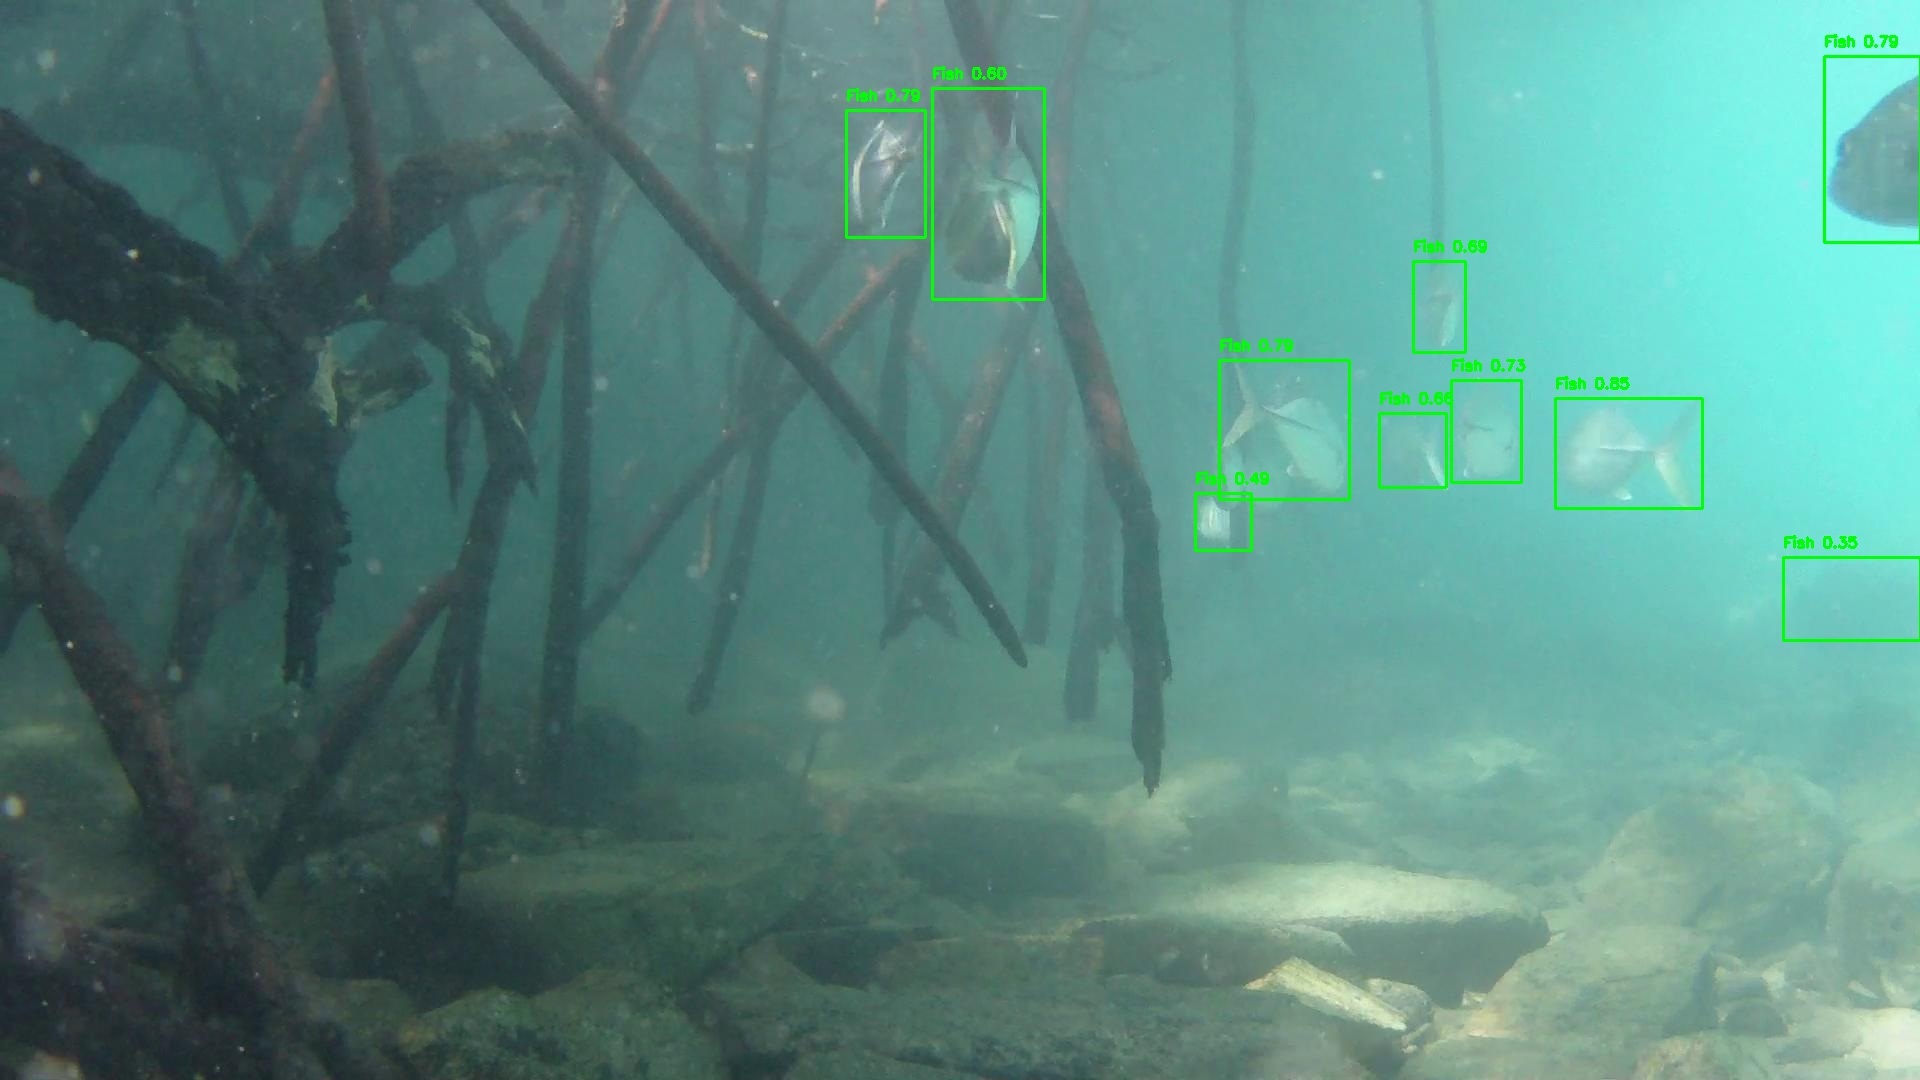

In [14]:
Image.open("/kaggle/working/YOLO/inference_output.jpg")